<a href="https://colab.research.google.com/github/groda/big_data/blob/master/ngrams_with_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90" alt="Logo Big Data for Beginners"></div></a>
# N-grams with PySpark


In this notebook we are going to extract _n-grams_ from a text file using PySpark.

N-grams in Natural Language Processing refer to sequences of tokens (or words) used to calculate the probability of a word given its preceding context. In a bigram model, the prediction for the next word relies on the single preceding word, while in a trigram model, it considers the two preceding words, and so forth.

We will utilize the PySpark distribution provided by `pip` with its integrated Spark engine running as a single Java virtual machine in _pseudo-distributed mode_.

More questions on PySpark are answered in the tutorial [PySpark on Google Colab](https://github.com/groda/big_data/blob/master/PySpark_On_Google_Colab.ipynb).

# Install PySpark

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=8b9ca31e0be60960331bde86455ee1742b5a16b82fe94fd527d05cd6253033db
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# Download a text file

In [2]:
FILENAME = 'don_quixote.txt'
!wget --no-clobber https://www.gutenberg.org/cache/epub/996/pg996.txt -O {FILENAME}

--2024-02-24 22:17:49--  https://www.gutenberg.org/cache/epub/996/pg996.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2391728 (2.3M) [text/plain]
Saving to: ‘don_quixote.txt’

don_quixote.txt     100%[===================>]   2.28M  13.2MB/s    in 0.2s    

2024-02-24 22:17:49 (13.2 MB/s) - ‘don_quixote.txt’ saved [2391728/2391728]



# Spark Web UI

The Spark Web UI

> “*provides a suite of web user interfaces (UIs) that you can use to monitor the status and resource consumption of your Spark cluster.*” (https://spark.apache.org/docs/3.5.0/web-ui.html)

See more in the official [Spark Documentation](https://spark.apache.org/docs/3.5.0/web-ui.html).


## Set `SPARK_HOME`

In [3]:
import subprocess
import os
# Run the script and capture its output
result = subprocess.run(["find_spark_home.py"], capture_output=True, text=True)

# Print or use the captured output
print("Output of find_spark_home.py:", result.stdout)

# set SPARK_HOME environment variable
os.environ['SPARK_HOME'] = result.stdout.strip()

Output of find_spark_home.py: /usr/local/lib/python3.10/dist-packages/pyspark



## Import `output` library if in Colab

The Web UI can be viewed in a separate windows or tab thanks to Colab's `output` library.


In [4]:
# true if running on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
 from google.colab import output

### Spark UI

In [5]:
if IN_COLAB:
  output.serve_kernel_port_as_window(4040, path='/jobs/index.html')

<IPython.core.display.Javascript object>

# Create a Spark context

In [6]:
from pyspark import SparkContext

sc = SparkContext(
    appName = "Ngrams with pyspark " + FILENAME
)

## View Spark context

In [7]:
sc

<SparkContext master=local[*] appName=Ngrams with pyspark don_quixote.txt>

# Create RDD from file

The second parameter ($80$)  indicates the desired number of partitions.

In [8]:
textFile = sc.textFile(FILENAME, 80)
print("textFile is of type: {}\nNumber of partitions: {}".format(type(textFile), textFile.getNumPartitions()))

textFile is of type: <class 'pyspark.rdd.RDD'>
Number of partitions: 80


# Generate trigrams

Change `n` to generate n-grams.

In [9]:
from operator import add
n = 3
ngrams = textFile \
            .flatMap(lambda x: [x.split()]) \
            .flatMap(lambda x: [tuple(y) for y in zip(*[x[i:] for i in range(n)])]) \
            .map(lambda x: (x, 1)) \
            .reduceByKey(add) \
            .sortBy(lambda x: x[1], ascending=False)

In [10]:
for (ngram, count) in ngrams.take(10):
    print("%s: %i" % (ngram, count))

('said', 'Don', 'Quixote,'): 235
('one', 'of', 'the'): 152
('said', 'Don', 'Quixote;'): 114
('Sancho,”', 'said', 'Don'): 98
('Quixote', 'of', 'La'): 97
('Don', 'Quixote', 'of'): 94
('as', 'well', 'as'): 85
('out', 'of', 'the'): 82
('that', 'I', 'am'): 82
('that', 'he', 'was'): 78


# View job in the Web UI

Here's the link:

In [11]:
if IN_COLAB:
  output.serve_kernel_port_as_window(4040, path='/jobs/index.html')

<IPython.core.display.Javascript object>

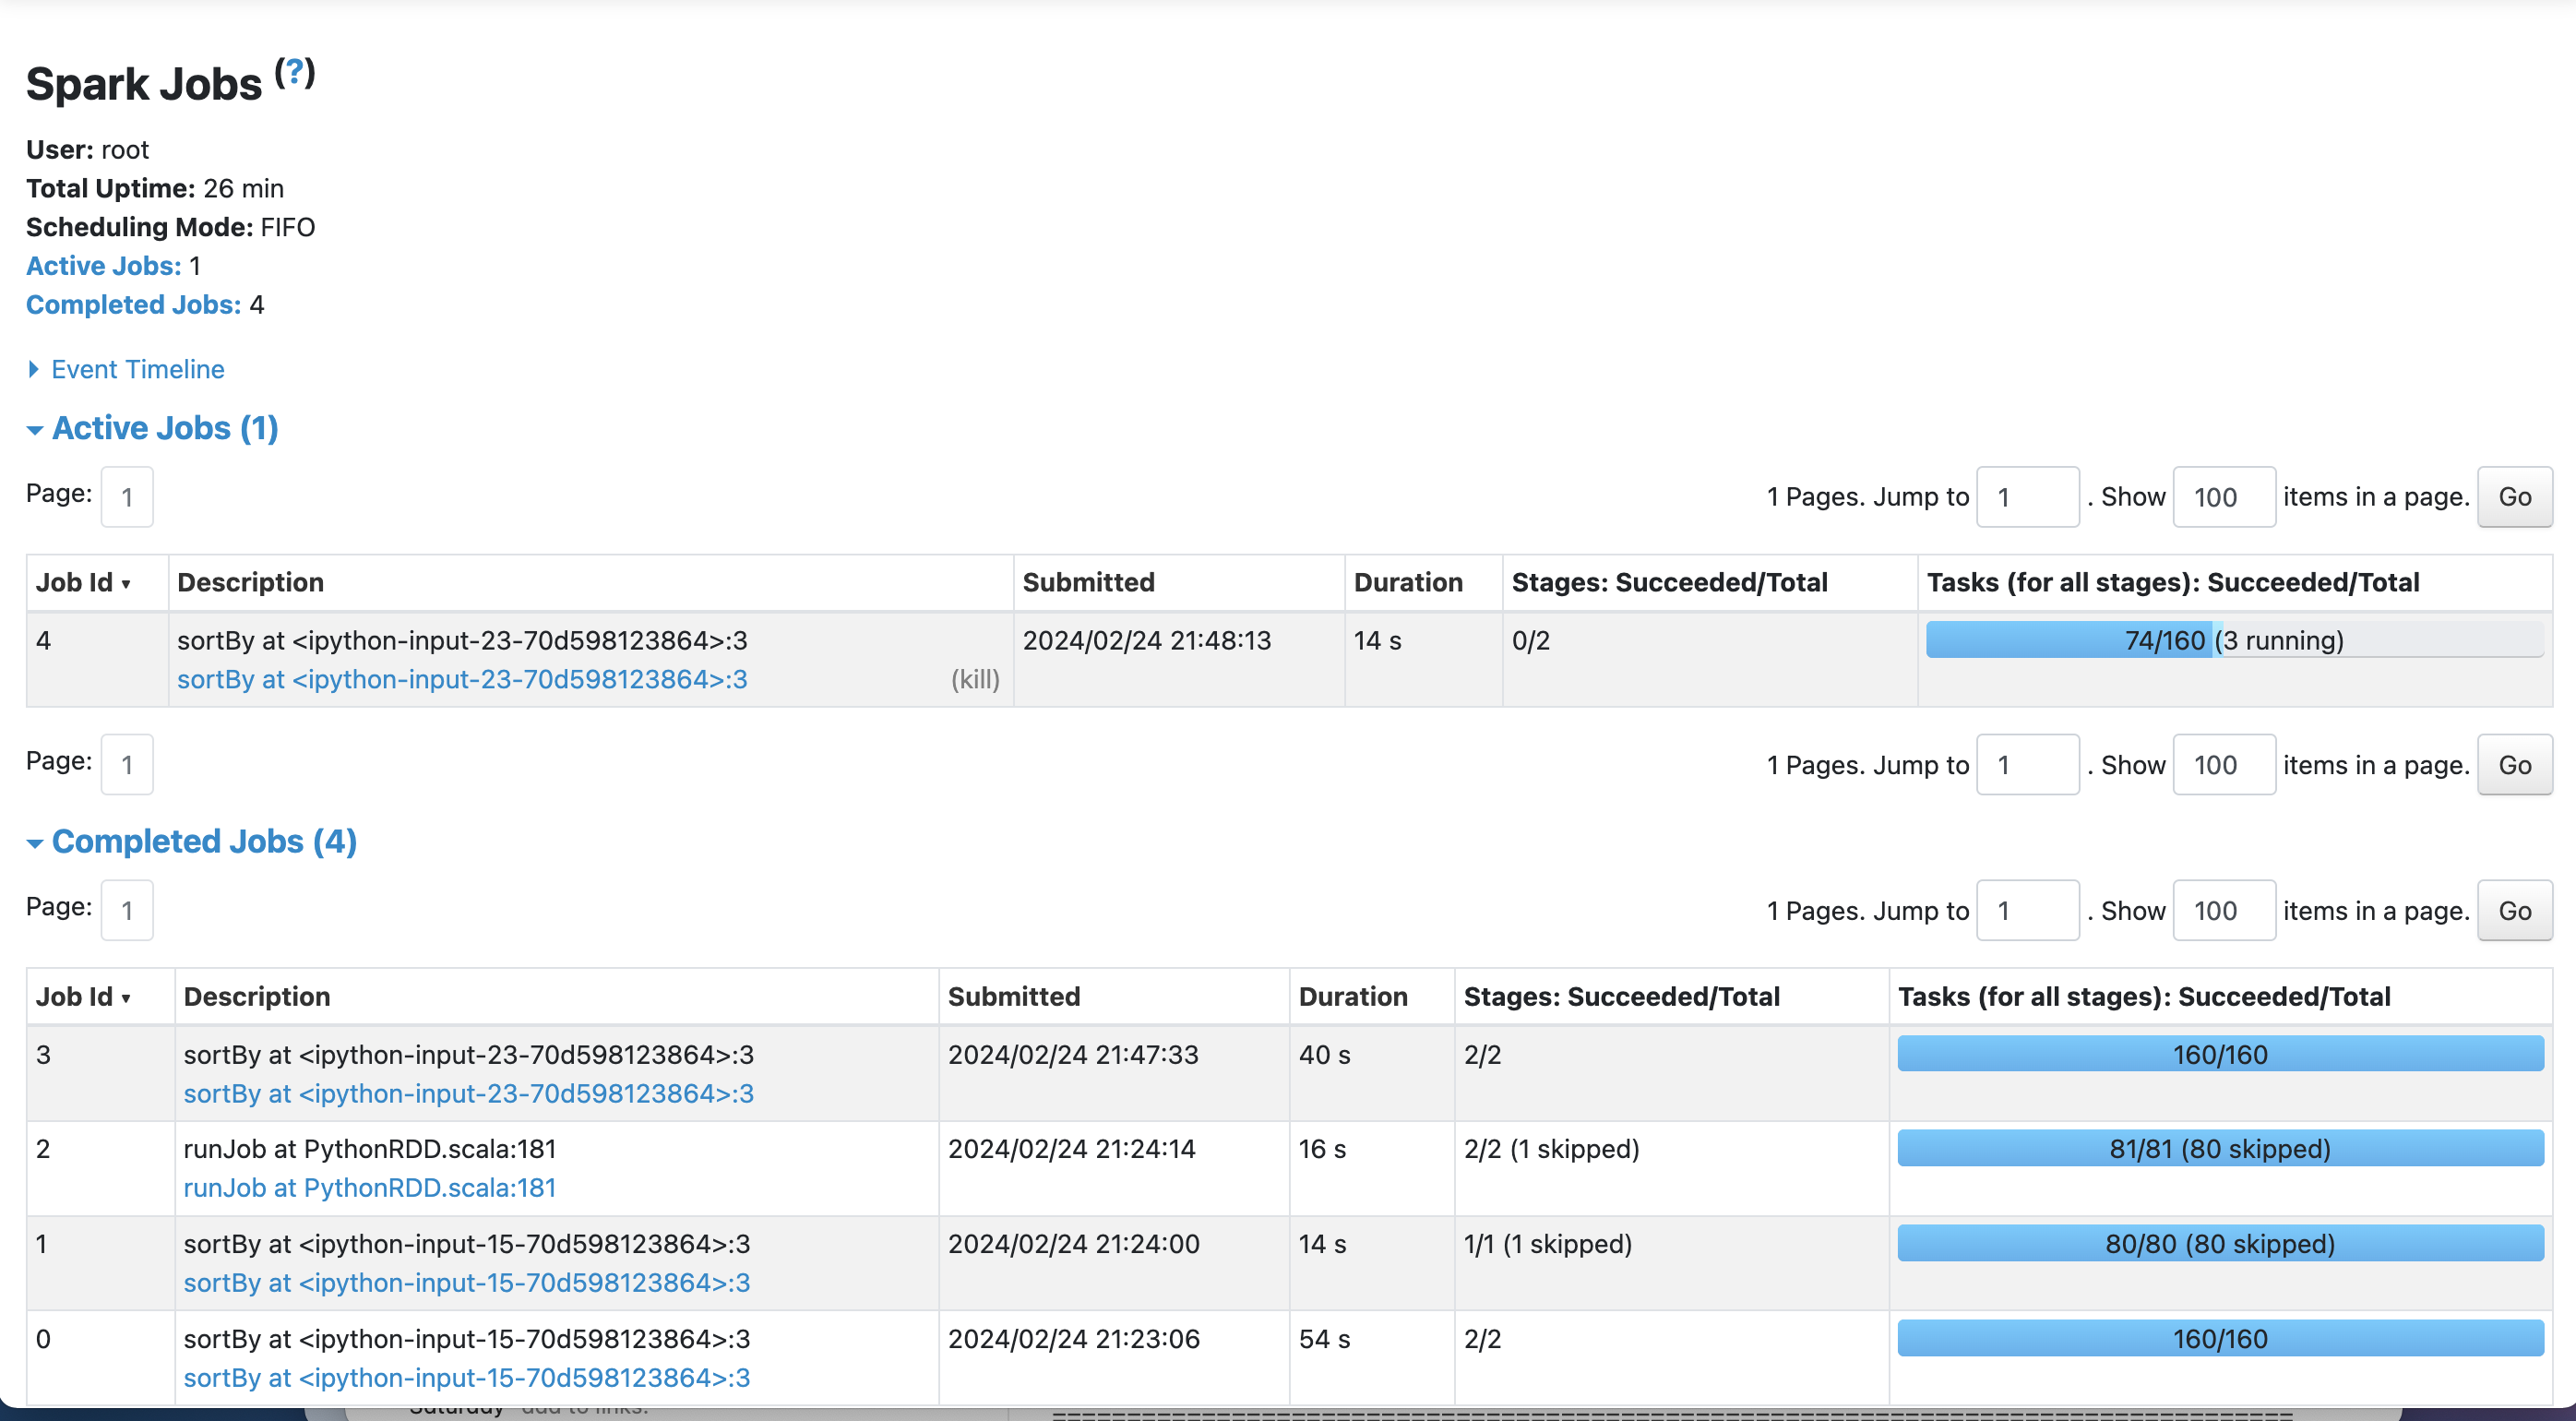

# Stop context

Stop the current Spark context to free resources. You also need to stop the current context to be able to create a new one.

In [12]:
sc.stop()

# Appendix: ChatGPT on n-grams

My prompt was: "who better than you to answer the following question? Where can I locate n-grams in the timeline of nlp/language models?"

In [13]:
# @title
from IPython.core.display import HTML
HTML("""
<div style="background-color:rgb(16, 163, 127,.2);border:2px solid rgb(16, 163, 127,.3);padding:3px;">
<svg fill="none" xmlns="http://www.w3.org/2000/svg" viewBox="0 0 320 320"  style="width:32px;height:32px;">
 <g fill="currentColor">
  <path d="m297.06 130.97c7.26-21.79 4.76-45.66-6.85-65.48-17.46-30.4-52.56-46.04-86.84-38.68-15.25-17.18-37.16-26.95-60.13-26.81-35.04-.08-66.13 22.48-76.91 55.82-22.51 4.61-41.94 18.7-53.31 38.67-17.59 30.32-13.58 68.54 9.92 94.54-7.26 21.79-4.76 45.66 6.85 65.48 17.46 30.4 52.56 46.04 86.84 38.68 15.24 17.18 37.16 26.95 60.13 26.8 35.06.09 66.16-22.49 76.94-55.86 22.51-4.61 41.94-18.7 53.31-38.67 17.57-30.32 13.55-68.51-9.94-94.51zm-120.28 168.11c-14.03.02-27.62-4.89-38.39-13.88.49-.26 1.34-.73 1.89-1.07l63.72-36.8c3.26-1.85 5.26-5.32 5.24-9.07v-89.83l26.93 15.55c.29.14.48.42.52.74v74.39c-.04 33.08-26.83 59.9-59.91 59.97zm-128.84-55.03c-7.03-12.14-9.56-26.37-7.15-40.18.47.28 1.3.79 1.89 1.13l63.72 36.8c3.23 1.89 7.23 1.89 10.47 0l77.79-44.92v31.1c.02.32-.13.63-.38.83l-64.41 37.19c-28.69 16.52-65.33 6.7-81.92-21.95zm-16.77-139.09c7-12.16 18.05-21.46 31.21-26.29 0 .55-.03 1.52-.03 2.2v73.61c-.02 3.74 1.98 7.21 5.23 9.06l77.79 44.91-26.93 15.55c-.27.18-.61.21-.91.08l-64.42-37.22c-28.63-16.58-38.45-53.21-21.95-81.89zm221.26 51.49-77.79-44.92 26.93-15.54c.27-.18.61-.21.91-.08l64.42 37.19c28.68 16.57 38.51 53.26 21.94 81.94-7.01 12.14-18.05 21.44-31.2 26.28v-75.81c.03-3.74-1.96-7.2-5.2-9.06zm26.8-40.34c-.47-.29-1.3-.79-1.89-1.13l-63.72-36.8c-3.23-1.89-7.23-1.89-10.47 0l-77.79 44.92v-31.1c-.02-.32.13-.63.38-.83l64.41-37.16c28.69-16.55 65.37-6.7 81.91 22 6.99 12.12 9.52 26.31 7.15 40.1zm-168.51 55.43-26.94-15.55c-.29-.14-.48-.42-.52-.74v-74.39c.02-33.12 26.89-59.96 60.01-59.94 14.01 0 27.57 4.92 38.34 13.88-.49.26-1.33.73-1.89 1.07l-63.72 36.8c-3.26 1.85-5.26 5.31-5.24 9.06l-.04 89.79zm14.63-31.54 34.65-20.01 34.65 20v40.01l-34.65 20-34.65-20z"></path>
  </svg>
  N-grams have been a fundamental concept in natural language processing (NLP) and language modeling for quite some time. Here's a brief overview of their timeline:
<ol>
<li><h3>Early Days (1950s-1960s):</h3></li> The concept of n-grams was introduced in the early days of computational linguistics and information theory. Researchers like Claude Shannon laid the groundwork for the statistical analysis of language.

<li><h3>Traditional NLP (1970s-1990s):</h3></li> N-grams became popular in traditional NLP during this period. Researchers used n-grams as a basic unit for language modeling and to capture local context in text. Simple n-gram models were widely used in tasks like machine translation and speech recognition.

<li><h3>Statistical Language Models (1990s-early 2000s):</h3></li> N-grams played a crucial role in statistical language modeling. Techniques like N-gram models and Hidden Markov Models were prevalent. These models formed the backbone of various NLP applications.

<li><h3>Advent of Neural Networks (2010s):</h3></li> With the resurgence of neural networks, traditional n-gram models faced competition from more sophisticated approaches. Neural network-based language models, such as recurrent neural networks (RNNs) and long short-term memory networks (LSTMs), started to outperform traditional n-gram models by capturing long-range dependencies in language.

<li><h3>Deep Learning and Sequence Models (2010s-2020s):</h3></li> Transformer-based architectures, like OpenAI's GPT series, further revolutionized NLP. These models, based on self-attention mechanisms, are capable of capturing contextual information effectively, making them more powerful than n-gram models. However, n-grams are still used in certain contexts and as components of more advanced models.

<li><h3>Current State (2020s and beyond):</h3></li> State-of-the-art language models, such as GPT-3 and its successors, leverage large-scale transformer architectures and pre-training on massive datasets. These models have largely surpassed the need for explicit n-gram modeling, as they can capture complex language patterns and dependencies across long sequences.


While n-grams were crucial in the early development of language models, the field has progressed significantly, and contemporary models have evolved beyond simple n-gram approaches. Nonetheless, understanding n-grams remains essential for foundational knowledge in NLP and language modeling.
</div>
""")

## What is the difference between n-grams and modern language models?

The distinction between n-grams and more modern models like transformers lies in their underlying modeling paradigms. N-grams rely on traditional statistical methods, specifically frequency counts, for language modeling. In contrast, transformers leverage deep learning techniques, which include complex neural network architectures, embeddings, and attention mechanisms. While both approaches involve statistical concepts, transformers harness the power of deep learning to capture intricate patterns and dependencies within data, allowing for more sophisticated language understanding and generation

## Comparing model sizes: a rough estimate of N-gram versus Transformer dimensions

An interesting point to note is that n-gram models have an order of magnitude smaller storage footprint compared to transformer models, especially in terms of model size. This discrepancy is apparent because transformers learn more intricate patterns, relationships, and context-aware representations, resulting in significantly larger model sizes.

Here are some rough estimates of model sizes just to get an idea:



*   **N-gram Model:** With a trigram model and a vocabulary of $50,000$ words, the model size might be in the megabyte range.
This is because the model primarily needs to store the counts for each trigram in the vocabulary, which is relatively straightforward.
*   **Transformer Model:**
Even for smaller transformer models with a vocabulary of $50,000$ words, the model size can be in the gigabyte range.
Transformers have a large number of parameters, and the model size increases significantly with model depth, attention heads, and the embedding dimension.
For instance, GPT-3, a large transformer model, has 175 billion parameters and a model size that's several gigabytes.



